In [1]:
import numpy as np
import treeQuadrature as tq
import matplotlib.pyplot as plt
from matplotlib import cm
from functools import partial

In [2]:
# # Add src to path
# import os,sys,inspect
# currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parentdir = os.path.dirname(currentdir)
# sys.path.insert(0,os.path.join(parentdir, 'results'))
# from problems import *

# Try to work out why quadCamel fails

In [7]:
problem = tq.exampleProblems.QuadCamel(20)
integ = tq.integrators.TreeIntegrator(1_000_000, tree=tq.trees.SimpleTree(P=50, split=tq.splits.kdSplit), 
                                      integral=tq.containerIntegration.midpointIntegral)
I = integ(problem)

In [3]:
from tqdm import tqdm

In [4]:
def safe_var(y):
    if y.shape[0] < 2:
        return 1e-3
    else:
        return np.max(np.var(y, axis=0))

In [38]:
split = tq.splits.minSseSplit

# integral = tq.containerIntegration.midpointIntegral
integral = partial(tq.containerIntegration.smcIntegral, n=5)

weighting_function = lambda container: np.max(container.y) - np.min(container.y) + 1
# weighting_function = lambda container: safe_var(container.y)
# weighting_function = lambda container: container.volume


queue = tq.queues.PriorityQueue
# queue = partial(tq.queues.ReservoirQueue, accentuation_factor=10)

In [ ]:
N = 1_000
base_N = 100
active_N = 5


As = list(range(1,10)) + list(range(10, 102, 5)) + ['inf']
Is = []
Is2 = []


for accentuation_factor in tqdm(As):
    iss = []
    for t in range(50):
        if accentuation_factor == 'inf':
            queue = tq.queues.PriorityQueue
            problem = tq.exampleProblems.Camel(2)
            integ = tq.integrators.LimitedSampleIntegrator(N, base_N, active_N, split, integral, weighting_function, queue)
            I = integ(problem)
            e = 100 * (I - problem.answer) / problem.answer
            iss.append(e)
        else:
            queue = partial(tq.queues.ReservoirQueue, accentuation_factor=10)
            problem = tq.exampleProblems.Camel(2)
            integ = tq.integrators.LimitedSampleIntegrator(N, base_N, active_N, split, integral, weighting_function, queue)
            I = integ(problem)
            e = 100 * (I - problem.answer) / problem.answer
            iss.append(e)
            
    Is.append(np.mean(iss))
    Is2.append(np.std(iss))

In [7]:
y2 = np.array(Is)
y1 = np.array(Is) - np.array(Is2)
y3 = np.array(Is) + np.array(Is2)

In [ ]:
plt.savefig

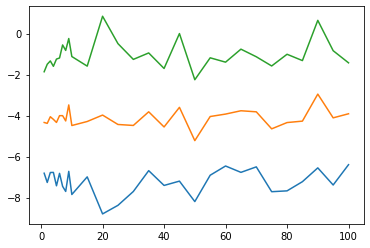

In [9]:
plt.plot(As[:-1], y1[:-1])
plt.plot(As[:-1], y2[:-1])
plt.plot(As[:-1], y3[:-1])

In [97]:
split = tq.splits.minSseSplit

# integral = tq.containerIntegration.midpointIntegral
integral = partial(tq.containerIntegration.smcIntegral, n=10)

weighting_function = lambda container: np.max(container.y) - np.min(container.y) + 1
# weighting_function = lambda container: safe_var(container.y)
# weighting_function = lambda container: container.volume


queue = tq.queues.PriorityQueue
# queue = partial(tq.queues.ReservoirQueue, accentuation_factor=1)

In [104]:
integ = tq.integrators.LimitedSampleIntegrator(2_000, 1_000, 50, split, integral, weighting_function, queue)

problem = tq.exampleProblems.QuadCamel(2)

G, N, fcs, cs, ns= integ(problem, return_all=True)

In [105]:
print(G, N, len(fcs), ns)

0.009938644721404096 22000 2000 0


pcntError: -0.6135527859590407
Samples:  22000
Container:  2000


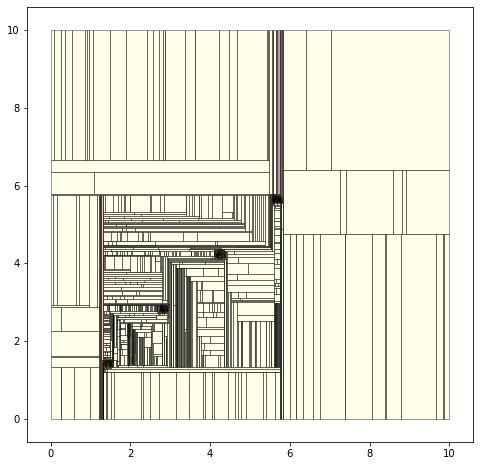

In [106]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.set_xlim([-0.6,10.6])
ax.set_ylim([-0.6,10.6])
cmap = cm.get_cmap('YlOrRd', 256)

cs = tq.utils.scale(cs)

print(f'pcntError: {100 * (G - problem.answer) / problem.answer}')
print("Samples: ", N)
print("Container: ", len(fcs))

for container, contribution in zip(fcs, cs):
    tq.visualisation.plotContainer(ax, container, plot_samples=False, fill=True, ec='black', facecolor=cmap(contribution), alpha=0.4)

In [107]:
ps = [c / sum(cs) for c in cs]
conts = np.random.choice(fcs, p=ps, size=(10_000))

In [108]:
samples = np.array([cont.rvs(1)[0] for cont in conts])

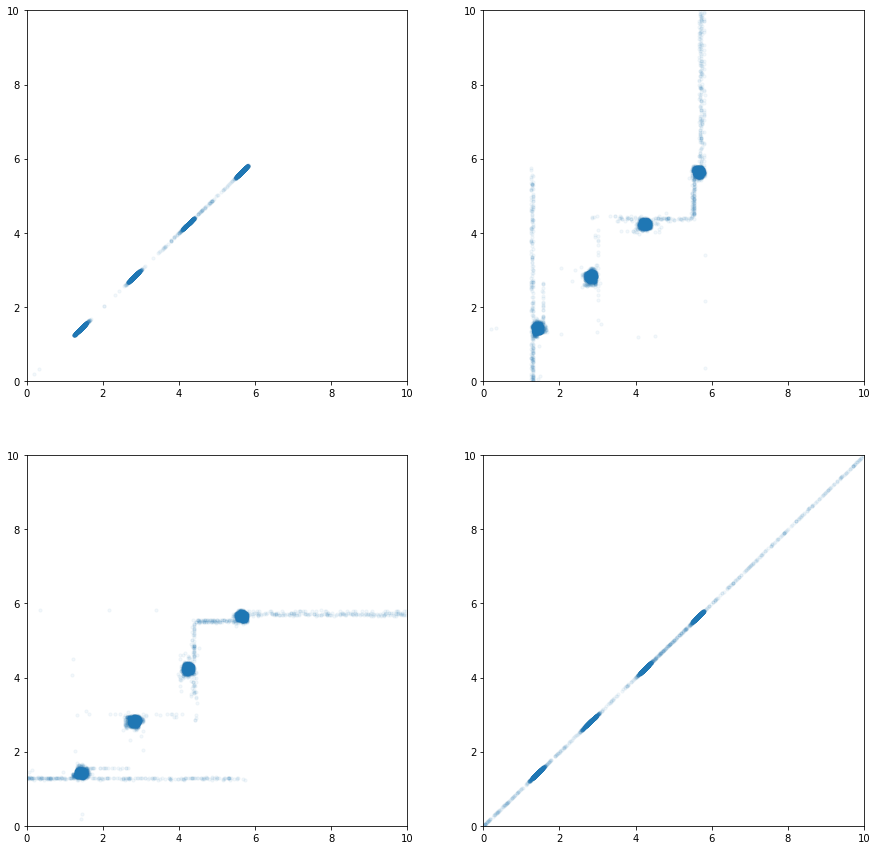

In [109]:
fig = plt.figure(figsize=(15,15))
D = 2
for i in range(D):
    for j in range(D):
        ax = fig.add_subplot(D, D, i*D + (j+1))
        ax.set_xlim([0,10])
        ax.set_ylim([0,10])
        ax.scatter(samples[:, i], samples[:, j], s=10, alpha=0.05)

In [2]:
class Chain:
    def __init__(self, j):
        self.lower = 1
        self.upper = (2*j) + 1
        self.x = j
        
    def update(self):
        if self.x == self.lower:
            step = np.random.choice([0, 1], p=[0.5, 0.5])
            self.x += step
        elif self.x == self.upper:
            step = np.random.choice([-1, 0], p=[0.5, 0.5])
            self.x += step
        else:
            step = np.random.choice([-1, 0, 1], p=[0.25, 0.5, 0.25])
            self.x += step
        return self.x

In [3]:
X = Chain(10.0)

In [4]:
from tqdm import tqdm

In [5]:
# vals = [X.update() for i in tqdm(range(100_000_000))]

100%|██████████| 100000000/100000000 [42:50<00:00, 38907.85it/s]


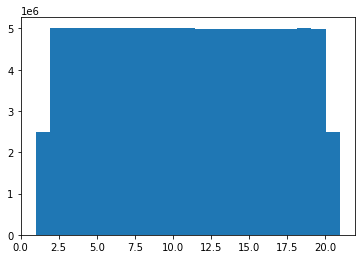

In [6]:
h = plt.hist(vals, bins=21)

In [9]:
vs = np.array(vals)

In [10]:
for i in range(1, (2*10) + 2):
    idxs = np.array(list(range(len(vals))))[vs == i]
    Hs = np.diff(idxs, n=1)
    print(i, Hs.mean())

1 40.05502513468586
2 20.000807437626595
3 19.99495604383959
4 19.973178093075845
5 19.942187532406205
6 19.932060466173148
7 19.941770924089322
8 19.9324357078219
9 19.948081061925507
10 19.9705220799321
11 20.004477606565956
12 20.055101462901224
13 20.06463751377941
14 20.061896048342813
15 20.043712589613055
16 20.031506723911676
17 20.04199554340371
18 20.024164475827614
19 19.994093068117564
20 20.01805351535585
21 40.041875938243415


In [11]:
Hs = []
for i in range(2, (2*10) + 1):
    idxs = np.array(list(range(len(vals))))[vs == i]
    Hss = np.diff(idxs, n=1)
    Hs.append(Hss.mean())
print(np.mean(Hs))

19.998717783932054


In [12]:
def f(x, y):

    cs = []
    state = 'looking for x'
    count = 1

    for i in vals:
        if state == 'looking for x':
            if i == x:
                state = 'looking for y'
                c = 0

        elif state == 'looking for y':

            c += 1

            if i == y:
                cs.append(c)
                state = 'looking for x'

        else:
            raise Exception()
            
    return np.mean(cs)

In [13]:
Hs = []
for i in range(1, 21):
    Hs.append(f(i, i+1))

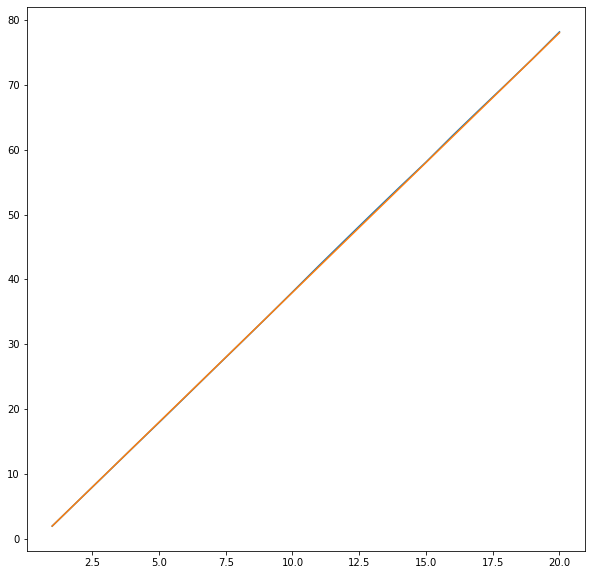

In [14]:
plt.figure(figsize=(10,10))
plt.plot(list(range(1,21)), Hs)
plt.plot(list(range(1,21)), -2 + 4*np.array(list(range(1,21))))

In [15]:
for i in range(1,11):
    print(i, f(i, 11))

1 199.71880609875774
2 197.7912003448028
3 191.82374583221554
4 181.6012852409269
5 167.63291332861704
6 149.72550019724966
7 127.74063981080418
8 101.89883747086498
9 72.04440900643796
